# single-cell Progeny Production analysis
This notebook provides a central place to integrate and analyze transcriptome and progeny production data.

## Notebook setup
First give paths and values to all variables. Then, load in data.

Python imports:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import numpy

import pandas as pd

import plotnine as p9

import scanpy

import scipy

import statsmodels.stats.multitest

Input data paths. Currently hardcoded.

In [2]:
matrix = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/matrix.mtx'
cell_barcodes = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/barcodes.tsv'
features = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/features.tsv'
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial3_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_background_freq_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_background_freq.csv.gz'
viral_bc_in_progeny_freq_csv = 'results/viral_progeny/scProgenyProduction_trial3_viral_bc_in_progeny_freq.csv.gz'

Global variables for this notebook:

In [3]:
expt = 'scProgenyProduction_trial3'
plot = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_correlations.pdf'
viral_genes = ['fluPB2', 'fluPB1', 'fluPA', 'fluHA', 'fluNA', 'fluNP', 'fluM', 'fluNS']
barcoded_viral_genes = ['fluHA', 'fluNA']

Style parameters. *N.b.* `CBPALETTE` is defined in imports above.

In [4]:
p9.theme_set(p9.theme_classic())

### Load data

Cell barcodes and infecting viral tags:

In [5]:
all_cells = pd.read_csv(viral_tag_by_cell_csv)
all_cells = all_cells[['cell_barcode',
                       'infected',
                       'infecting_viral_tag']]
display(all_cells)

,cell_barcode,infected,infecting_viral_tag
0,AAACCCAGTAACAAGT,False,none
1,AAACCCATCATTGCTT,False,none
2,AAACGAAAGATGTTGA,False,none
3,AAACGAAGTACTTCCC,True,both
4,AAACGAAGTAGACGTG,True,wt
...,...,...,...
3363,TTTGATCTCCCGTTCA,False,none
3364,TTTGATCTCGCATTGA,True,wt
3365,TTTGGAGAGTTGCCTA,False,none
3366,TTTGGAGGTATCGTTG,True,wt


**Transcriptome** viral barcode frequencies:

In [6]:
transcriptome_viral_bc_freqs = pd.read_csv(viral_bc_background_freq_csv)
assert set(transcriptome_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
display(transcriptome_viral_bc_freqs)

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0,0.000000,False
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0,0.000000,False
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0,0.000000,False
3,AAACGAAGTACTTCCC,True,both,0.448272,fluHA,NaN,0,0.000000,False
4,AAACGAAGTAGACGTG,True,wt,0.040116,fluHA,AAGTAAGCGACATGAG,93,0.001731,True
...,...,...,...,...,...,...,...,...,...
9185,TTTGATCTCCCGTTCA,False,none,0.000109,fluNA,NaN,0,0.000000,False
9186,TTTGATCTCGCATTGA,True,wt,0.063156,fluNA,NaN,0,0.000000,False
9187,TTTGGAGAGTTGCCTA,False,none,0.000070,fluNA,NaN,0,0.000000,False
9188,TTTGGAGGTATCGTTG,True,wt,0.024534,fluNA,ACATCTTATTTACACG,15,0.000230,True


**Progeny** viral barcode frequencies:

*N.b. For now just work with supernatant data. Remove second_infection frequencies.*

In [7]:
progeny_viral_bc_freqs = pd.read_csv(viral_bc_in_progeny_freq_csv)
assert set(progeny_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .rename(columns={'barcode': 'viral_barcode',
                                           'tag': 'infecting_viral_tag',
                                           'mean_freq': 'freq_progeny',
                                           'mean_count': 'sup_count'}))
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .query('source == "supernatant"'))
progeny_viral_bc_freqs = progeny_viral_bc_freqs.drop(columns = 'source')
display(progeny_viral_bc_freqs)

,infecting_viral_tag,gene,viral_barcode,freq_progeny
0,syn,fluHA,AAAAAAGCACGAGCAG,2.507618e-07
1,syn,fluHA,AAAAAATCCTTCAGCA,2.574453e-07
2,syn,fluHA,AAAAAATGGCGACGCT,2.574453e-07
3,syn,fluHA,AAAAAATTGGTTTACT,2.574453e-07
4,syn,fluHA,AAAAACACTCACAAGT,2.574453e-07
...,...,...,...,...
61196,wt,fluNA,TTTTTCCCTTACATAT,2.399886e-07
61197,wt,fluNA,TTTTTCTTACGATCAC,2.399886e-07
61198,wt,fluNA,TTTTTCTTCGAGATAG,3.062051e-06
61199,wt,fluNA,TTTTTGGGATCATTGC,1.142142e-06


Cell-gene matrix:

In [8]:
adata = scanpy.read_mtx(matrix)
adata.var = pd.read_csv(cell_barcodes,
                        names=['cell_barcode'])
adata.obs = pd.read_csv(features,
                        sep='\t',
                        names=['ensemble_id', 'gene', 'feature_type'])

print(f"Read cell-gene matrix of {adata.n_vars} cells and {adata.n_obs} genes")

assert set(viral_genes).issubset(set(adata.obs['gene'])), 'lack viral genes'

Read cell-gene matrix of 3368 cells and 30959 genes


### Cross-check data
Use assert statements to ensure that that the number and identity of cell barcodes is identical between data sources and that the infecting viral tag assigned to each cells matches.

In [12]:
assert all_cells['cell_barcode'].nunique() == \
       transcriptome_viral_bc_freqs['cell_barcode'].nunique() == \
       adata.var['cell_barcode'].nunique(), \
       "Number of cells discrepancy"

assert set(all_cells['cell_barcode']) == \
       set(transcriptome_viral_bc_freqs['cell_barcode']) == \
       set(adata.var['cell_barcode']), \
       "Cell barcodes do not match between data sources"

assert all_cells.reset_index(drop=True) \
       .equals((transcriptome_viral_bc_freqs[['cell_barcode',
                                              'infected',
                                              'infecting_viral_tag']]
                .drop_duplicates()
                .reset_index(drop=True))), \
       "Infecting viral tag or status not consistent between data sources"

### Plot raw data
Plot data from each source without filtering or processing. This is mostly for exploration and transparency.

#### Viral barcode transcription
***Note:*** `NA` values (0 counts) in the transcriptome data are plotted on the far left side of this graph at `1e-8`.

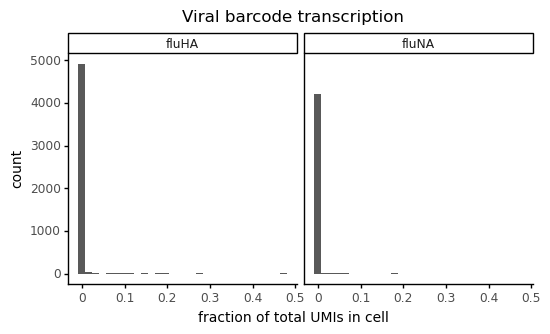

<ggplot: (8774933433061)>

In [20]:
fig = (p9.ggplot((transcriptome_viral_bc_freqs.fillna(1e-8)),
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)